# Import Libraries

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import string
# Import word_tokenize and stopwords from nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS
from string import punctuation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

import nltk
import nltk.corpus
from gensim.models.word2vec import Word2Vec
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score

In [86]:
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

In [3]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

Testing Nela Features for further work

In [ ]:
!pip install nela_features

In [ ]:
from nela_features.nela_features import NELAFeatureExtractor

newsarticle = "This is just a random text in order to test this great the feature extractor" 

nela = NELAFeatureExtractor()

# Extract all feature groups at once
feature_vector, feature_names = nela.extract_all(newsarticle)

# Extract each feature group independently
#feature_vector, feature_names = nela.extract_style(newsarticle) 
#feature_vector, feature_names = nela.extract_complexity(newsarticle) 
#feature_vector, feature_names = nela.extract_bias(newsarticle)
#feature_vector, feature_names = nela.extract_affect(newsarticle) 
#feature_vector, feature_names = nela.extract_moral(newsarticle) 
#feature_vector, feature_names = nela.extract_event(newsarticle)

In [ ]:
print(feature_vector)
print (feature_names)

# Import dataset

In [4]:
from google.colab import files
uploaded = files.upload()

Saving test.tsv to test.tsv
Saving train.tsv to train.tsv


In [6]:
def read_file(filename): 
  tain_file = open(filename)
  df = pd.read_csv(tain_file, delimiter="\t", header = None)
  df.rename(columns = {0:'ID', 1:'label', 2:'statement', 3:'subject', 
                           4:'speaker', 5:'job_title', 6:'state', 7:'party', 
                           8:'barely_true_counts', 9:'false_counts', 10:'half_true_counts',
                           11:'mostly_true_counts', 12:'pants_on_fire_counts', 13:'location'}, inplace = True)
  return df

train = read_file('train.tsv')
test = read_file('test.tsv')
#valid_df = read_file('valid.tsv')
train.head()

,ID,label,statement,subject,speaker,job_title,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,location
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [7]:
# Shape of each set

print("Shape of TRAIN DATA: ", train.shape)
print("Shape of TEST DATA: ", test.shape)

Shape of TRAIN DATA:  (10240, 14)
Shape of TEST DATA:  (1267, 14)


[Text(0, 0, 'false'),
 Text(0, 0, 'half-true'),
 Text(0, 0, 'mostly-true'),
 Text(0, 0, 'true'),
 Text(0, 0, 'barely-true'),
 Text(0, 0, 'pants-fire')]

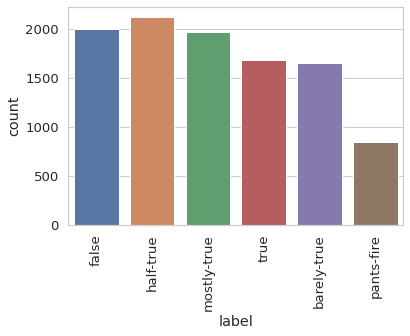

In [8]:
# The distrubution of labels
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "label", data = train)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

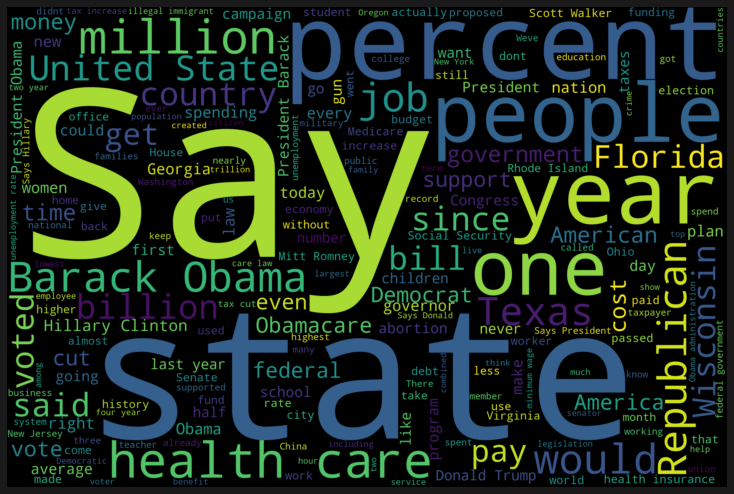

In [9]:
# WordCloud for test dataset
text = ''
for news in train.statement.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (10, 7.5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

In [ ]:
# Saving the original Data for future

train_orig = train.copy()
test_orig = test.copy()

In [10]:
# drop other columns of the data
def content_only(df):
  new_df = df[['label', 'statement']]
  return new_df

train = content_only(train)
test = content_only(test)
#valid = content_only(valid)
train.head()

,label,statement
0,false,Says the Annies List political group supports ...
1,half-true,When did the decline of coal start? It started...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo..."
3,false,Health care reform legislation is likely to ma...
4,half-true,The economic turnaround started at the end of ...


# Text Pre-Processing

In [11]:
def process_statements(text):
    
    # Tokenize the words
    tokenized = word_tokenize(text)

    # Remove the stop words
    tokenized = [token for token in tokenized if token not in stopwords.words("english")] 

    # Lemmatize the words, changing text to lowercase
    lemmatizer = WordNetLemmatizer()
    tokenized = [lemmatizer.lemmatize(token.lower(), pos='a') for token in tokenized]

    # Remove non-alphabetic characters and keep the words contains three or more letters
    tokenized = [token for token in tokenized if token.isalpha() and len(token)>2]
    
    return tokenized
    
# Call the function and store the result into a new column
#train["Processed"] = train['Statement'].str.lower().apply(process_statements)

# Print the first fifteen rows of Processed
#display(train[["Processed"]].head(15))

In [15]:
# Creating X and Y test
X_train = train["statement"]
X_test = test["statement"]

In [13]:
# transform y train

label_train = train["label"]
label_test = test["label"]
def transformLabel(newLabels):
  labels = newLabels.copy()
  for i in range(len(labels)):
    if labels[i] == ('pants-fire'):
      labels[i] = 0.0
    elif labels[i] == 'false':
      labels[i] = 0.0
    elif labels[i] == 'barely-true':
      labels[i] = 0.0
    elif labels[i] == 'true':
      labels[i] = 1.0
    elif labels[i] == 'mostly-true':
      labels[i] = 1.0
    else:
      labels[i] = 0.0
  labels = np.asarray(labels).astype('float32')
  return labels

y_train = transformLabel(label_train)
y_test = transformLabel(label_test)
#y_valid = transformLabel(label_valid)


print(y_train)

[0. 0. 1. ... 0. 0. 0.]


In [16]:
# Apply text pre-processing, then vectorize the text so the models can actually interpret it
vectorizer = TfidfVectorizer(analyzer=process_statements)
x_train_vectorized = vectorizer.fit_transform(X_train)
x_test_vectorized = vectorizer.transform(X_test)

In [17]:
print(x_train_vectorized)

  (0, 2601)	0.3964316618130959
  (0, 30)	0.33666064253400446
  (0, 9759)	0.3116854938641983
  (0, 4372)	0.3403465781726439
  (0, 7488)	0.3332179180997368
  (0, 5821)	0.3752681135465199
  (0, 445)	0.49799986716152295
  (0, 8760)	0.12904922797568633
  (1, 165)	0.2010759910003482
  (1, 1329)	0.2890425637797335
  (1, 4177)	0.22300484856706312
  (1, 7662)	0.15180446403077794
  (1, 912)	0.3035572591877658
  (1, 10170)	0.2023461874541922
  (1, 4128)	0.22527084660832758
  (1, 6563)	0.27850852573528995
  (1, 9485)	0.5033154443901114
  (1, 9484)	0.27023519451614997
  (1, 1816)	0.28039853574983103
  (1, 2510)	0.31133074448966613
  (1, 10935)	0.1998461251291283
  (2, 5215)	0.28462189659728576
  (2, 2996)	0.39650173726889065
  (2, 947)	0.3305269891917723
  (2, 1327)	0.23892954258827953
  :	:
  (10237, 8895)	0.3456251458001171
  (10237, 10009)	0.1489215963688747
  (10237, 8760)	0.08521751304697446
  (10238, 5781)	0.44461569455541516
  (10238, 2347)	0.424240581611776
  (10238, 3233)	0.433402460741326

In [18]:
print (x_train_vectorized.shape)
print (x_test_vectorized.shape)
print (y_train.shape)
print (y_test.shape)

(10240, 11179)
(1267, 11179)
(10240,)
(1267,)


# Logistic Regression

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(x_train_vectorized, y_train)
logR_predicted = log_reg.predict(x_test_vectorized)
print(f"{log_reg.__class__.__name__} accuracy: {log_reg.score(x_test_vectorized, y_test)}")

LogisticRegression accuracy: 0.6095648765190121


In [ ]:
print(classification_report(y_test, logR_predicted))
print('\n')
print(confusion_matrix(y_test, logR_predicted))

              precision    recall  f1-score   support

       False       0.60      0.46      0.52      1169
        True       0.62      0.74      0.67      1382

    accuracy                           0.61      2551
   macro avg       0.61      0.60      0.60      2551
weighted avg       0.61      0.61      0.60      2551



[[ 536  633]
 [ 363 1019]]


In [ ]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(log_reg, x_train_vectorized, y_train, cv=5)
cv_results['test_score'].mean()

0.60498046875

# Random Forest

In [ ]:
random_forest = RandomForestClassifier(n_estimators=10, max_depth=100)
random_forest.fit(x_train_vectorized, y_train)

print(f"{random_forest.__class__.__name__} accuracy: {random_forest.score(x_test_vectorized, y_test)}")

RandomForestClassifier accuracy: 0.5895727165817326


In [ ]:
rForest_pred = random_forest.predict(x_test_vectorized)
print(classification_report(y_test, rForest_pred))
print('\n')
print(confusion_matrix(y_test, rForest_pred))

              precision    recall  f1-score   support

       False       0.58      0.38      0.46      1169
        True       0.59      0.77      0.67      1382

    accuracy                           0.59      2551
   macro avg       0.59      0.57      0.56      2551
weighted avg       0.59      0.59      0.57      2551



[[ 442  727]
 [ 320 1062]]


In [ ]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(random_forest, x_train_vectorized, y_train, cv=5)
cv_results['test_score'].mean()

array([0.59912109, 0.57519531, 0.56298828, 0.59033203, 0.58642578])

# Multinomial Naive Bayes

In [ ]:
multi_nb = MultinomialNB()
multi_nb.fit(x_train_vectorized, y_train)
print(f"{multi_nb.__class__.__name__} accuracy: {multi_nb.score(x_test_vectorized, y_test)}")

MultinomialNB accuracy: 0.6203125


In [ ]:
NaiveB_pred = multi_nb.predict(x_test_vectorized)
print(classification_report(y_test, NaiveB_pred))
print('\n')
print(confusion_matrix(y_test, NaiveB_pred))

              precision    recall  f1-score   support

       False       0.59      0.29      0.39      1065
        True       0.63      0.85      0.72      1495

    accuracy                           0.62      2560
   macro avg       0.61      0.57      0.56      2560
weighted avg       0.61      0.62      0.59      2560



[[ 312  753]
 [ 219 1276]]


In [ ]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(multi_nb, x_train_vectorized, y_train, cv=5)
cv_results['test_score'].mean()

#SVM

In [94]:
svm = svm.LinearSVC()
svm.fit(x_train_vectorized, y_train)
print(f"{svm.__class__.__name__} accuracy: {svm.score(x_test_vectorized, y_test)}")

LinearSVC accuracy: 0.6053670086819258


In [ ]:
svm_pred = svm.predict(x_test_vectorized)

print(classification_report(y_test, svm_pred))
print('\n')
print(confusion_matrix(y_test, svm_pred))

              precision    recall  f1-score   support

       False       0.50      0.48      0.49      1065
        True       0.64      0.66      0.65      1495

    accuracy                           0.59      2560
   macro avg       0.57      0.57      0.57      2560
weighted avg       0.58      0.59      0.58      2560



[[509 556]
 [506 989]]


In [ ]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(svm, x_train_vectorized, y_train, cv=5)
cv_results['test_score'].mean()

# LSTM with GloVe embedding

In [95]:
!pip install glove_python

     |████████████████████████████████| 266kB 9.0MB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=700243 sha256=23db178fbd35a2d23b7727ad8c68db5e7483fccbce4467b4971f766882590681
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


In [59]:
table = str.maketrans('', '', string.punctuation)

def makeWords(sentences):
  wordList = []
  for headline in sentences:
    words = headline.split(' ')
    stripped = [w.strip().translate(table) for w in words]
    wordList.append(stripped)
  return wordList

words_train = makeWords(X_train)
words_test = makeWords(X_test)
#words_valid = makeWords(statement_valid)

In [60]:
MAX_WORDS = 100000 # max number of words for tokenizer
MAX_SEQUENCE_LENGTH = 1000 # max length of each sentences, including padding
EMBEDDING_DIM = 100 # embedding dimensions for word vectors

In [88]:
#X_rain to sequences

# prepare tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS)

#preparing vocabulary
tokenizer.fit_on_texts(words_train)

#converting text into integer sequences
sequences = tokenizer.texts_to_sequences(words_train) 

#padding to prepare sequences of same length
X_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post')

# record the size of the vocab
vocab_size=len(tokenizer.word_index) + 1 #+1 for padding
print(vocab_size)

13411


In [91]:
# X_test to sequences

tokenizer = Tokenizer(num_words=MAX_WORDS)

#preparing vocabulary
tokenizer.fit_on_texts(words_test)

#converting text into integer sequences
sequences = tokenizer.texts_to_sequences(words_test) 

#padding to prepare sequences of same length
X_test = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post')

In [ ]:
# X_valid to sequences
#tokenizer = Tokenizer(num_words=max_features)

#preparing vocabulary
#tokenizer.fit_on_texts(words_valid)

#converting text into integer sequences
#sequences = tokenizer.texts_to_sequences(words_valid) 

#padding to prepare sequences of same length
#X_valid = pad_sequences(sequences, maxlen=maxlen, padding = 'post')

# GloVe embeddings

In [ ]:
## Glove_Embedding Using Gensim
from __future__ import print_function
import argparse
import pprint
import gensim

from glove import Glove
from glove import Corpus

In [97]:
# Build the corpus dictionary and the cooccurrence matrix.
print('Pre-processing corpus')

corpus_model = Corpus()
corpus_model.fit(words_train, window=10)
#Corpus.save('corpus.model')
        
print('Dict size: %s' % len(corpus_model.dictionary))
print('Collocations: %s' % corpus_model.matrix.nnz)

Pre-processing corpus
Dict size: 14910
Collocations: 634864


In [110]:
# Fit glove vectorizer with concurrence matrix from Corpus class
glove = Glove(no_components=100, learning_rate=0.05)
glove.fit(corpus_model.matrix)
glove.add_dictionary(corpus_model.dictionary)

In [104]:
from google.colab import drive
drive.mount('/content/drive')

In [107]:
# Pre-trained embedding

EMBEDDING_FILE = ("/content/drive/My Drive/glove.6B.100d.txt")

In [108]:
# load the whole embedding into memory
embeddings_index = dict()
f = open(EMBEDDING_FILE)

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [109]:
# check few word to numerical replesentation
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break

the -> 1
in -> 2
of -> 3
to -> 4
a -> 5
and -> 6
says -> 7
for -> 8
is -> 9
that -> 10


In [111]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, word_index):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(word_index) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in word_index.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [112]:
# create a weight matrix for words
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

# Defining Neural Network

In [113]:
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

del embedding_matrix

In [114]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         1341100   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,458,477
Trainable params: 117,377
Non-trainable params: 1,341,100
_________________________________________________________________


In [115]:
history = model.fit(sequences_matrix, y_train, validation_split=0.3, epochs=5)

Epoch 1/5
224/224 [==============================] - 14s 56ms/step - loss: 0.6622 - accuracy: 0.6316 - val_loss: 0.6459 - val_accuracy: 0.6507
Epoch 2/5
224/224 [==============================] - 12s 55ms/step - loss: 0.6376 - accuracy: 0.6482 - val_loss: 0.6424 - val_accuracy: 0.6380
Epoch 3/5
224/224 [==============================] - 12s 55ms/step - loss: 0.6305 - accuracy: 0.6513 - val_loss: 0.6424 - val_accuracy: 0.6432
Epoch 4/5
224/224 [==============================] - 12s 56ms/step - loss: 0.6170 - accuracy: 0.6616 - val_loss: 0.6621 - val_accuracy: 0.6169
Epoch 5/5
224/224 [==============================] - 13s 58ms/step - loss: 0.6415 - accuracy: 0.6474 - val_loss: 0.6676 - val_accuracy: 0.6504


Evaluate the model on the test set

In [116]:
y_pred_word2vec = (model.predict(test_sequences_matrix) > 0.5).astype("int")

In [117]:
print("Accuracy is {} for LSTM with word2vec embedding.".format(accuracy_score(y_test, y_pred_word2vec)))

Accuracy is 0.6448303078137332 for LSTM with word2vec embedding.


In [118]:
print(classification_report(y_test, y_pred, zero_division = 1))

              precision    recall  f1-score   support

         0.0       0.64      0.99      0.78       818
         1.0       0.27      0.01      0.01       449

    accuracy                           0.64      1267
   macro avg       0.46      0.50      0.40      1267
weighted avg       0.51      0.64      0.51      1267



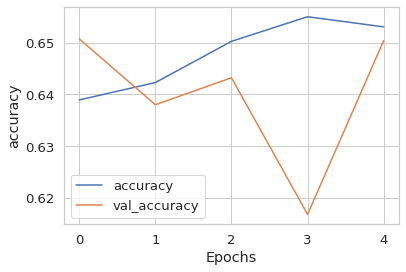

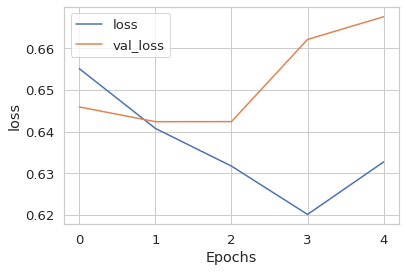

In [119]:
#plot accuracy and loss
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")